<h2>Step 1: Compiling a List of the Largest Cities in the US</h2>

First, the city name, latitude, longitude, and population are extracted from 'largest_us_cities.csv', a file containing the cities in the US with a population over 30,000. Cities with a population over 200,000 were added to the dictionary, and Anchorage and Honolulu were excluded as they skewed the positioning of the map. Next, using the haversine distance formula, which determines the distance between pairs of cities, cities close to one another were excluded and used a population heuristic to determine which city should should be kept.

In [308]:
file2 = open('largest_us_cities.csv', 'r') 
large_cities = file2.readlines()

large_city_data = {}
for i in range(1, len(large_cities)):
    large_city_values = large_cities[i].strip().split(';')
    lat_long = large_city_values[-1].split(',')
    if ((int(large_city_values[-2]) >= 200000) and (large_city_values[0] != "Anchorage") and (large_city_values[0] != "Honolulu") and (large_city_values[0] != "Greensboro")):
        large_city_data[large_city_values[0]] = [lat_long[0], lat_long[1], large_city_values[-2]]

def haversine(point_a, point_b):
    lon1, lat1 = point_a[0], point_a[1]
    lon2, lat2 = point_b[0], point_b[1]
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r

for i in list(large_city_data.keys()):
    for j in list(large_city_data.keys()):
        if ((i != j) and haversine((float(large_city_data[i][0]), float(large_city_data[i][1])), (float(large_city_data[j][0]),
            float(large_city_data[j][1]))) < 80.0):
            if (large_city_data[j][2] > large_city_data[i][2]):
                large_city_data[i] = [np.nan, np.nan, large_city_data[i][2]]
            else:
                large_city_data[j] = [np.nan, np.nan, large_city_data[j][2]]
large_city_data['Chicago'] = [41.8781136, -87.6297982, 2718782]

print("Here is a subset of the large cities:")
print(list(large_city_data.keys())[:10])

Here is a subset of the large cities:
['Cleveland', 'Boise City', 'Lubbock', 'Kansas City', 'Montgomery', 'Columbus', 'Buffalo', 'Sacramento', 'Henderson', 'Spokane']


<h2>Step 2: Plotting K-Means Clusters and Cluster Centers Using Basemap</h2>

First, a function is created with seven parameters: df1, num_cluster, typeof, path, size, add_large_city, and figsize. Using the basemap library, depending on the typeof parameter, geographic models of the US and world are generated. Furthermore, the figsize parameter changes the model size depending on its value. A dictionary is created where the keys are the cluster labels, subdivided by latitude and longitude. The values contain the latitude and longitude for each headline for each cluster label.

A list of colors is intitialized, and specific colors are assigned to each cluster label. The latitude and longitude points are plotted using these color values on the geographic models made above. If the add_large_city parameter is true, the largest cities will also be added to the graph. The figure is saved to a ".png" file using the path parameter.

In [309]:
def print_k_means(df1, num_cluster, typeof, path, size, add_large_city, figsize):
    if (typeof == "US"):
        map_plotter = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33, lat_2=45)
    else:
        map_plotter = Basemap()
    if (figsize):
        fig = plt.figure(figsize = (24,16))
    else:
        fig = plt.figure(figsize = (12,8))
    coordinates = []
    for index in df1.index:
        coordinates.append([df1['latitude'][index], df1['longitude'][index], df1['cluster_label'][index]])
    
    cluster_vals = {}
    for i in range(num_cluster):
        cluster_vals[str(i)+"_long"] = []
        cluster_vals[str(i)+"_lat"] = []
    
    for index in df1.index:
        cluster_vals[str(df1['cluster_label'][index])+'_long'].append(float(df1['longitude'][index]))
        cluster_vals[str(df1['cluster_label'][index])+'_lat'].append(float(df1['latitude'][index]))
        
    num_list = [i for i in range(num_cluster)]
    color_list = ['rosybrown', 'lightcoral', 'indianred', 'brown',
                 'maroon', 'red', 'darksalmon', 'sienna', 'chocolate', 'sandybrown', 'peru',
                 'darkorange', 'burlywood', 'orange', 'tan', 'darkgoldenrod', 'goldenrod', 'gold', 'darkkhaki',
                 'olive', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'chartreuse',
                 'darkseagreen', 'forestgreen', 'darkgreen', 'mediumseagreen', 'mediumaquamarine',
                 'turquoise', 'lightseagreen', 'darkslategrey', 'darkcyan',
                 'cadetblue', 'deepskyblue', 'lightskyblue', 'steelblue', 'lightslategrey',
                 'midnightblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumpurple', 'rebeccapurple',
                 'thistle', 'plum', 'violet', 'purple', 'fuchsia', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink',
                 'palevioletred']
    colors = [color_list[i] for i in range(num_cluster+1)]

    for target,color in zip(num_list, colors):
         map_plotter.scatter(cluster_vals[str(target)+'_long'], cluster_vals[str(target)+'_lat'], latlon=True, s = size, c = color)
         map_plotter.shadedrelief()
    if (add_large_city):
        for index in list(large_city_data.keys()):
            if (large_city_data[index][1] != np.nan):
                x, y = map_plotter(large_city_data[index][1], large_city_data[index][0])
                plt.plot(x, y, "ok", markersize = 4)
                plt.text(x, y, index, fontsize = 16)
    plt.show()
    fig.savefig(path)

The print_k_means function is run on the df_no_us dataframe to make a scatterplot of the latitude and longitudes for headlines pertaining to the US. Next, a geographic center to each cluster is determined and stored in another dataframe called df_center_us. The print_k_means function is run on the df_center_us dataframe and adds large cities to determine the cities closest to the disease outbreak centers. Additionally, the size is increased for easier readability. A similar process is run for df_no_world. Each of the dataframes are stored in a ".csv" file.

/Users/adityamittal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


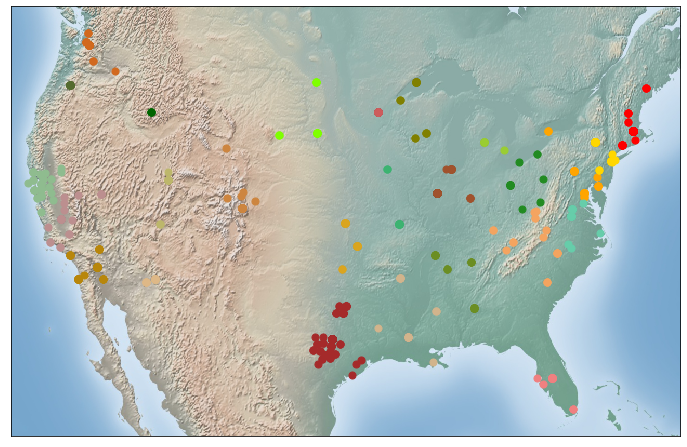

/Users/adityamittal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


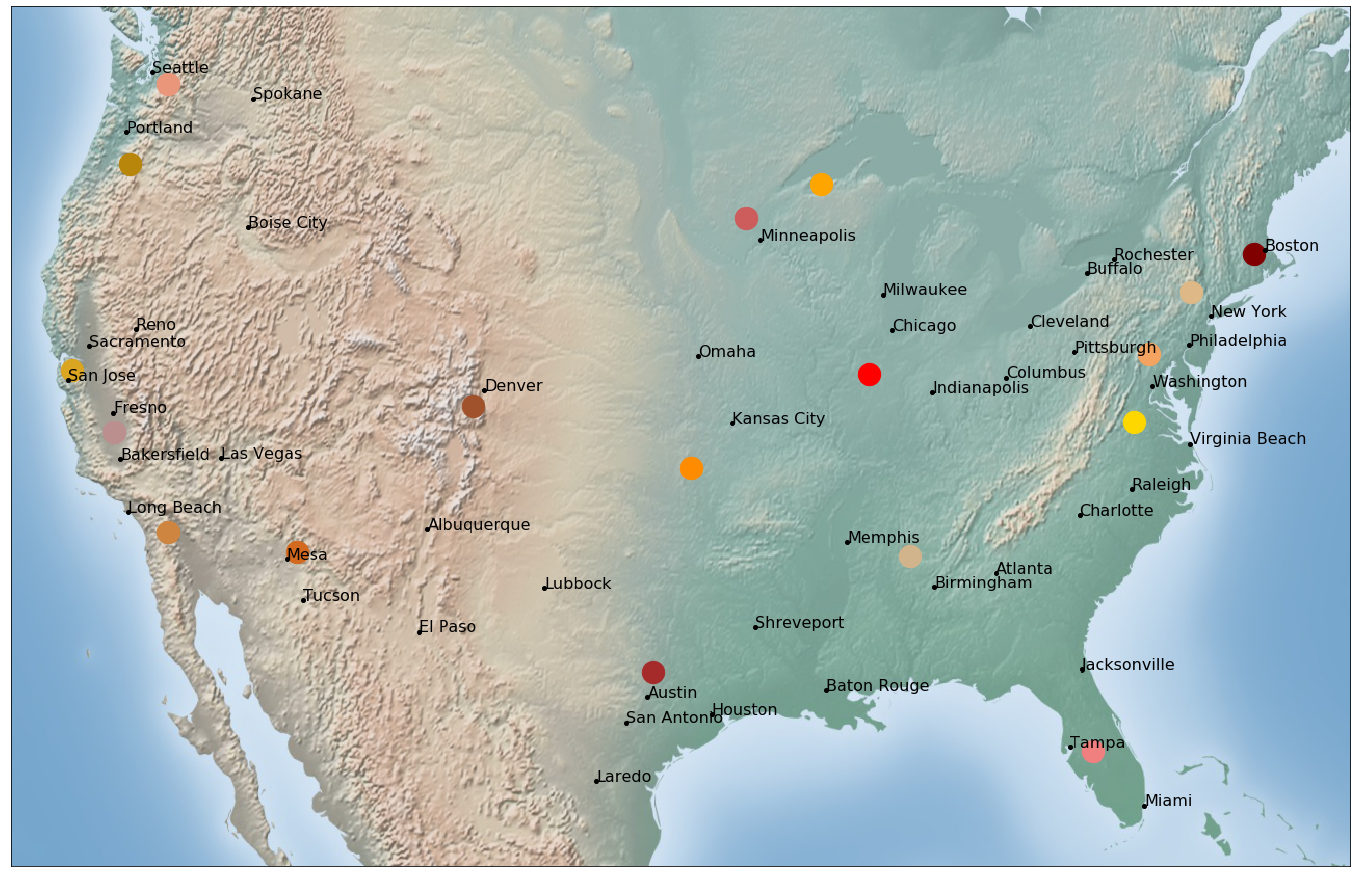

/Users/adityamittal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/adityamittal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


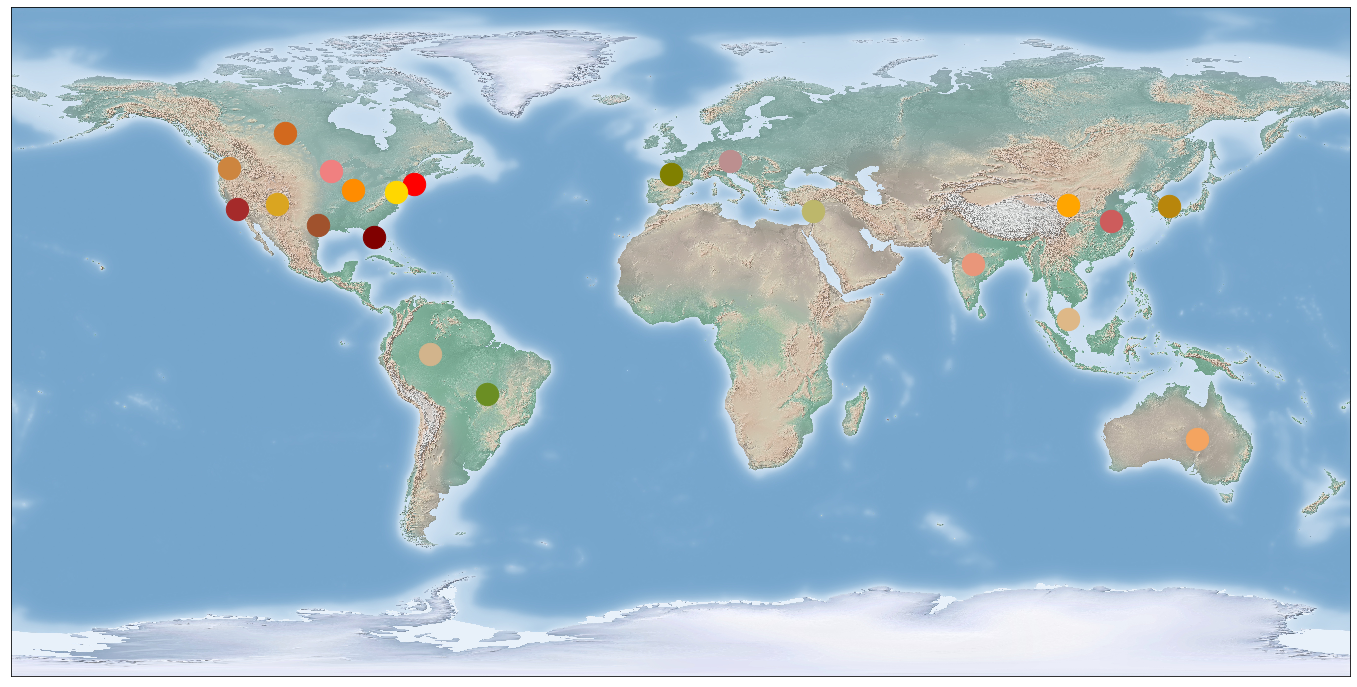

In [310]:
#Printing Results and Saving Results
print_k_means(df_no_us, us_clusters, "US", "corona_disease_outbreaks_us.png", 50, False, False)
df_no_us.to_csv("corona_disease_outbreaks_us.csv")

# print_k_means(df_no_world, world_clusters, "world", "corona_disease_outbreaks_world.png")
# df_no_world.to_csv("corona_disease_outbreaks_world.csv")


df_center_us = {'latitude': [], 'longitude':[] , 'cluster_label': []}
for i in range(us_clusters):
    df_1 = df_no_us.loc[df_no_us['cluster_label'] == i]
    df_1 = df_1.reset_index()
    del df_1['index']
    latitude = []
    longitude = []
    for index in df_1.index:
        latitude.append(float(df_1['latitude'][index]))
        longitude.append(float(df_1['longitude'][index]))
    df_1['latitude'] = latitude
    df_1['longitude'] = longitude
    sum_latitude = df_1['latitude'].sum()
    sum_longitude = df_1['longitude'].sum()
    if (len(df_1['latitude']) >= 20):
        df_center_us['latitude'].append(sum_latitude/(len(df_1['latitude'])))
        df_center_us['cluster_label'].append(i)
        df_center_us['longitude'].append(sum_longitude/(len(df_1['longitude'])))
df_center_us = pd.DataFrame(data = df_center_us)


for index in df_center_us.index:
    df_center_us['cluster_label'][index] = index

print_k_means(df_center_us, len(df_center_us['latitude']), "US", "corona_disease_outbreaks_us_centers.png", 500, True, True)
df_center_us.to_csv("corona_disease_outbreaks_us_centers.csv")

df_center_world = {'latitude': [], 'longitude':[] , 'cluster_label': []}
for i in range(world_clusters):
    df_1 = df_no_world.loc[df_no_world['cluster_label'] == i]
    df_1 = df_1.reset_index()
    del df_1['index']
    latitude = []
    longitude = []
    for index in df_1.index:
        latitude.append(float(df_1['latitude'][index]))
        longitude.append(float(df_1['longitude'][index]))
    df_1['latitude'] = latitude
    df_1['longitude'] = longitude
    sum_latitude = df_1['latitude'].sum()
    sum_longitude = df_1['longitude'].sum()
    if (len(df_1['latitude']) >= 10):
        df_center_world['latitude'].append(sum_latitude/(len(df_1['latitude'])))
        df_center_world['cluster_label'].append(i)
        df_center_world['longitude'].append(sum_longitude/(len(df_1['longitude'])))
df_center_world = pd.DataFrame(data = df_center_world)


for index in df_center_world.index:
    df_center_world['cluster_label'][index] = index

print_k_means(df_center_world, len(df_center_world['latitude']), "world", "corona_disease_outbreaks_world_centers.png", 500, False, True)
df_center_us.to_csv("corona_disease_outbreaks_world_centers.csv")